<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Notes:  Reading Machine Learning Papers**

**Paper:** An image is worth 16x16 words (Attention is all you need)

**Transformers:** This is a deep-learning model that adopts the mechanism of self-attention, differentially weighing the significance of each part of input data (Wikipedia).

**Attention:** This is the most vivid part of an image that captures your eyes and delivers the image as a whole. E.g., a dog in the grass by a tree under daylight.

Attention uses selective focus, importance weighting, context dependence, relationships, and probabilistic models.

**Sources:**
- arxiv.org
- AK-Twitter (@akallz)
- vit-pytorch
- paperswithcode.com

We will transform the paper into a usable/deeper-get set.

**Paper overview:**
1. Get set up
2. Introduce machine learning paper replication
3. Replicate ViT for food-vision-mini
4. Train a custom ViT
5. Feature extraction with a pretrained ViT

---

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-applying-vit-to-food-vision-mini.png" alt="appyling the vision transformer architecture to FoodVision mini" width=900/>

We're going to be focusing on building the ViT architecture as per the original ViT paper and applying it to FoodVision Mini.

| **Topic** | **Contents** |
| ----- | ----- |
| **[0. Getting setup](https://www.learnpytorch.io/08_pytorch_paper_replicating/#0-getting-setup)** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **[1. Get data](https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data)** | Let's get the pizza, steak and sushi image classification dataset we've been using and build a Vision Transformer to try and improve FoodVision Mini model's results. |
| **[2. Create Datasets and DataLoaders](https://www.learnpytorch.io/08_pytorch_paper_replicating/#2-create-datasets-and-dataloaders)** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **[3. Replicating the ViT paper: an overview](https://www.learnpytorch.io/08_pytorch_paper_replicating/#3-replicating-the-vit-paper-an-overview)** | Replicating a machine learning research paper can be bit a fair challenge, so before we jump in, let's break the ViT paper down into smaller chunks, so we can replicate the paper chunk by chunk. |
| **[4. Equation 1: The Patch Embedding](https://www.learnpytorch.io/08_pytorch_paper_replicating/#4-equation-1-split-data-into-patches-and-creating-the-class-position-and-patch-embedding)** | The ViT architecture is comprised of four main equations, the first being the patch and position embedding. Or turning an image into a sequence of learnable patches. |
| **[5. Equation 2: Multi-Head Attention (MSA)](https://www.learnpytorch.io/08_pytorch_paper_replicating/#5-equation-2-multi-head-attention-msa)** | The self-attention/multi-head self-attention (MSA) mechanism is at the heart of every Transformer architecture, including the ViT architecture, let's create an MSA block using PyTorch's in-built layers. |
| **[6. Equation 3: Multilayer Perceptron (MLP)](https://www.learnpytorch.io/08_pytorch_paper_replicating/#6-equation-3-multilayer-perceptron-mlp)** | The ViT architecture uses a multilayer perceptron as part of its Transformer Encoder and for its output layer. Let's start by creating an MLP for the Transformer Encoder. |
| **[7. Creating the Transformer Encoder](https://www.learnpytorch.io/08_pytorch_paper_replicating/#7-create-the-transformer-encoder)** | A Transformer Encoder is typically comprised of alternating layers of MSA (equation 2) and MLP (equation 3) joined together via residual connections. Let's create one by stacking the layers we created in sections 5 & 6 on top of each other.  |
| **[8. Putting it all together to create ViT](https://www.learnpytorch.io/08_pytorch_paper_replicating/#8-putting-it-all-together-to-create-vit)** | We've got all the pieces of the puzzle to create the ViT architecture, let's put them all together into a single class we can call as our model. |
| **[9. Setting up training code for our ViT model](https://www.learnpytorch.io/08_pytorch_paper_replicating/#9-setting-up-training-code-for-our-vit-model)** | Training our custom ViT implementation is similar to all of the other model's we've trained previously. And thanks to our `train()` function in `engine.py` we can start training with a few lines of code. |
| **[10. Using a pretrained ViT from `torchvision.models`](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset)** | Training a large model like ViT usually takes a fair amount of data. Since we're only working with a small amount of pizza, steak and sushi images, let's see if we can leverage the power of transfer learning to improve our performance. |
| **[11. Make predictions on a custom image](https://www.learnpytorch.io/08_pytorch_paper_replicating/#11-make-predictions-on-a-custom-image)** | The magic of machine learning is seeing it work on your own data, so let's take our best performing model and put FoodVision Mini to the test on the infamous *pizza-dad* image (a photo of my dad eating pizza). |

# 0. Getting Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1.  Get data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create datasets and dataloaders

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ef688f0cf70>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

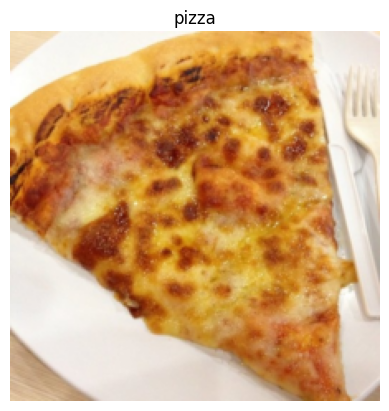

In [9]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

#3 Replicating ViT Paper

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>



**Attention Formulae:**

\begin{align}
        \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
    \end{align}

- $ Q =  Query$
- $ K =  Key$
- $ V =  Value$
- $ T =  Transpose$

**Looking at a whole machine learning research paper can be intimidating. So, in order to make it more approachable, we can break it down into smaller pieces:**

1. **Inputs:** What goes into the model.
2. **Outputs:** What comes out of the model.
3. **Layers:** Takes input, manipulates it with a function, e.g., self-attention.
4. **Blocks:** Collection of layers.
5. **Model:** A collection of blocks.

**Steps on breaking down the model:**

1. Visual overview of the architecture.
2. Four equations defining each block.
3. Different hyperparameters used.
4. Test.




**Visual overview of the architecture**

1. **Model Architecture Overview**
   - We will split the image into learnable patches instead of pixels.
     - e.g., split the image into 9 parts and send them to the transformer.
   - So the inputs are the patch position embeddings.
   - The layers are:
     - Embedded patches
     - Norm
     - Multihead attention
     - Norm
     - MLP (Multi-Layer Perceptron)
   - Notice that the input to the first norm is also added to the second norm in the diagram, indicated by the arrow.

- We have two blocks:
  - **MSA block:** Norm + Multihead attention
  - **MLP block:** Norm + MLP

**MSA** = Multi-Self-Attention layer  
**MLP** = Multi-Layer Perceptron



Equation 1

To handle 3D image, we reshape the image
$x \in \mathbb{R}^{H \times W \times C}$ (x is an element of real number with
dimension height, width, color channel) into a
sequence of flattened 2D paches $x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$
where ($P^2$) is the resolution of the image patch.
$N = \frac{H \times W}{P^2}$ is the resulting number of patches

The standard Transformer receives input as 1D thus we
multiply the resulting patches by E to map the
patches onto D dimensions.
Thus
$Z_0 = \left[ x_{\text{class}}; x_p^1E; x_p^2E; \ldots; x_p^NE \right] + E_{\text{pos}}$

- $(x_{\text{class}}$) is the class token.
- $(x_p^iE$) are the patch embeddings for $(i \in \{1, \ldots, N\}$).
- $(E_{\text{pos}}$) is the positional embedding.

(The first equation of section 3.1 GELU ViT)
Where p represents Patch, x_in the input
and pos is the positional embedding.



--------------------



```python
x-input = [class_token, image_patch_1, image_patch_2 ...image_patch_N] +
          [class_token_pos, image_patch_1_pos, image_patch_2_pos
          pos, ... image_patch_N]
```

$z'_l = \text{MSA}(\text{LN}(z_{l-1})) + z_{l-1}, \quad l = 1 \ldots L$

MSA is in pytorch

$z_l = \text{MLP}(\text{LN}(z'_l)) + z'_l$

MLP function is in pytorch:

$z_l$ and $z'_l$ are residual connection:
In the process of training, if the tensors being trained
on become too small, our loss gradient will explode.
Thus we can retain the input and pass it to the
input of the next block

* Equation 2 in pseudocode:
```
x_output_msa_block = MSA_layer(LN_layer(x_input)) + x_input
```
Equation 3
```
x_output_MLP_block = MLP_layer(LN_layer(x_output_msa_block)) +
                     x_output_msa_block
```
--------------------


Equation 4

$y = \text{MLP}(\text{LN}(z_L^0))$    where LN = Layer Norm

We know that MLP = Multilayer perceptron which is
a network neural network with x number of layers

So, we will add a class token to the beginning of
The sequence of embedded patches ie ($z_0^0$ = x_class)

Pseudocode:
```
y = LN
y = Linear_Layer(LN_layer(x_output_MLP_Block))
```
--------------------



Here is Table 1 from the Vision Transformer (ViT) paper:

| Model     | Layers | Hidden size | MLP size | Heads | Params |
|-----------|--------|-------------|----------|-------|--------|
| ViT-Base  | 12     | 768         | 3072     | 12    | 86M    |
| ViT-Large | 24     | 1024        | 4096     | 16    | 307M   |
| ViT-Huge  | 32     | 1280        | 5120     | 16    | 632M   |

This table provides details of the different Vision Transformer model variants, specifying the number of layers, hidden size, MLP size, number of attention heads, and the total number of parameters for each model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

# 4. Equation 1: Split data into patches and creating the class, position and patch embedding


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

## 4.1 Equation 1: Calculate input and output shapes

    - **Q1: How do we convert our image to patches?**
        - We know that:
            - Layers = input -> function -> output
        - **What is the input shape?**
        - **What is the output shape?**
            - Input shape: `(224, 224, 3)`
            - Output shape (patches):
              \[
              x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}
              \]
            - \( H = \text{Height}, W = \text{Width} \)
            - \( P = \text{Patch size}, N = \frac{H \times W}{P^2} \)
            - \( C = \text{Color channel}, D = \text{Embedding dimension} \)

In [10]:
# create example values
height = 224
width = 224
color_channel = 3
patch_size = 16

# calculae number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [11]:
# input shape
embedding_layer_input_shape = (height, width, color_channel)

# output_shape
embedding_layer_output_shape = (number_of_patches, (patch_size**2) * color_channel )
print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


## 4.2 Turning a single image into patches

We started by converting/plotting the first row of the image using plt.imshow where we plotted img[0-patch_size, all, all] ie (:) means include all rows and as item/object after a colon means we stop at that item.

We then split the raw image into patches by using cutplots.

Subplots returns figure and axes/array of axes.

We use axes as iterators to loop through vectors of images.

We then did this on 2D ie height and width.

(-0.5, 223.5, 223.5, -0.5)

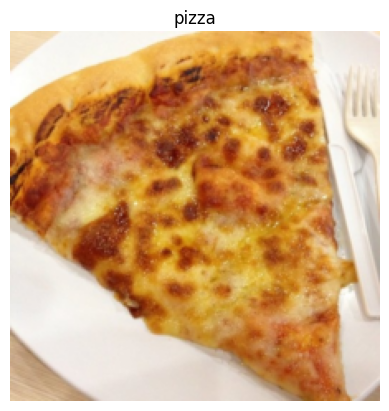

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

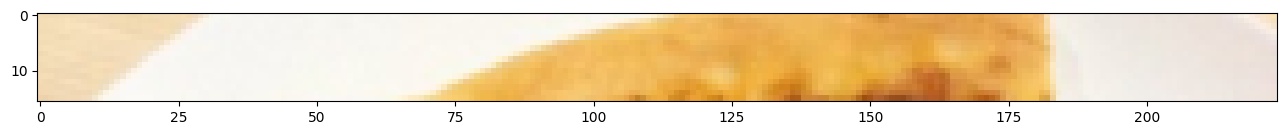

In [13]:
# get top row of image
image_permuted = image.permute(1,2,0)

# index to plot the top row of image
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

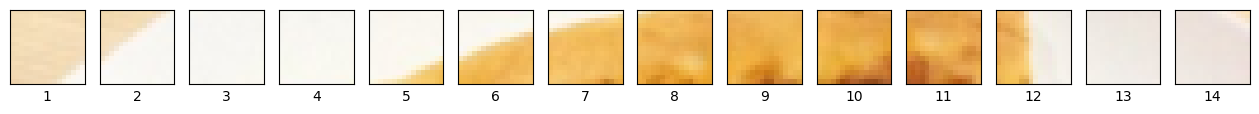

In [14]:
# plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [15]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=img_size // patch_size,
#                         ncols=img_size // patch_size,
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# # Loop through height and width of image
# for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
#   for j, patch_width in enumerate(range(0, img_size, patch_size)):
#     # Plot the permuted image on the different axes
#     axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
#                                     patch_width:patch_width+patch_size, # iterate through width
#                                     :]) # get all color channels
#     # Set up label information for each subplot (patch)
#     axs[i, j].set_ylabel(i+1,
#                          rotation="horizontal",
#                          horizontalalignment="right",
#                          verticalalignment="center")
#     axs[i, j].set_xlabel(j+1)
#     axs[i, j].set_xticks([])
#     axs[i, j].set_yticks([])
#     axs[i, j].label_outer()

# # Set up a title for the plot
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
# plt.show()

#  this code takes a toll on the cpu. uncomment it only for testing

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


## 4.3 Creating image patches and turning them into patch embeddings

    - We can create image patches and turn them into patch embeddings in a single step using `torch.nn.Conv2d` and setting:
        - Kernel size = patch size
        - Stride = patch size
    - Check out ViT chapter (3.1).

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [17]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [310, 676, 565, 414, 421]


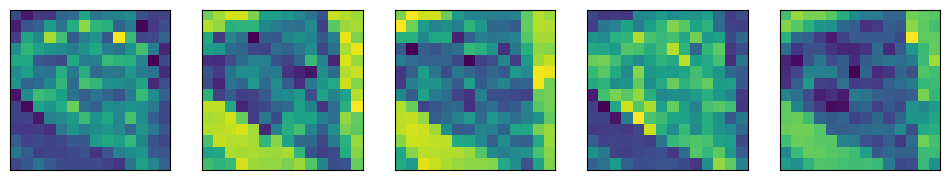

In [18]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
# get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :] # learnable representation of our image
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1537, -0.1723, -0.1516, -0.1629, -0.1562, -0.1423, -0.0878,
           -0.0710, -0.1294, -0.1450, -0.1340, -0.1849, -0.1505, -0.1506],
          [-0.1835, -0.1506, -0.1370, -0.0708, -0.1034, -0.1882, -0.1958,
           -0.0343, -0.0898, -0.1054, -0.0563, -0.1736, -0.1600, -0.1788],
          [-0.1037, -0.0711, -0.1802, -0.1874, -0.0151, -0.1006, -0.0846,
           -0.1082, -0.1183, -0.0710, -0.1019, -0.0685, -0.1271, -0.1414],
          [-0.1282, -0.1364, -0.1697, -0.0961, -0.0820, -0.1204, -0.1238,
           -0.0946, -0.0842, -0.1999, -0.0974, -0.1287, -0.1515, -0.1759],
          [-0.1544, -0.1372, -0.0280, -0.1029, -0.1360, -0.0652, -0.0506,
           -0.0583, -0.0137, -0.1732, -0.1626, -0.1803, -0.2075, -0.0707],
          [-0.0788, -0.1191, -0.0928, -0.0846, -0.1243, -0.1845, -0.1725,
           -0.1171, -0.1361, -0.1026, -0.1491, -0.0574, -0.1727, -0.0879],
          [-0.0726, -0.0549, -0.1024, -0.1491, -0.0550, -0.1109, -0.2062,
           -0.0588, -0.1098, -0.

## 4.4 Flattening the patch embedding with torch.nn.Flatten

    - We can flatten the height and width dimensions into P.
    - For example, `(C, 16, 16)` -> `(C, 768)`.
    - Formula for flattening:
      \[
      x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}
      \]
    - HB: Feature maps are a learnable representation of an image.
    - Embeddings: Tensor that represents the image data.

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2, end_dim=3) # we want to flatten the last two items in our patch embedding

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])


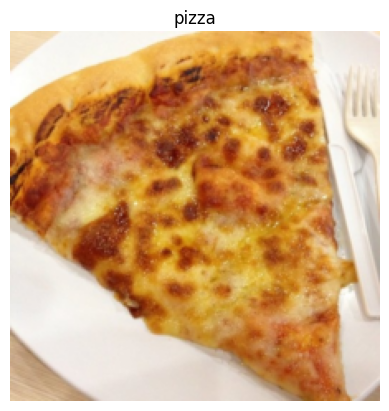

In [22]:
# putting everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(image.shape)

# turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

# flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(image_out_of_conv_flattened.shape)

In [23]:
# rearrage output to match the output formula ~~ N * (P^2 * c)
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (Batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (Batch_size, number_of_patches, embedding_dimension)


In [24]:
# visualize the sequence feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False);


## 4.5 Turning the ViT patch embedding layer into a pytorch module


Steps:
1. Create a class called `PatchEmbedding`.
2. Initialize with appropriate parameters e.g., channels, embedding dimensions, patch size.
3. Create a layer to turn an image into embedding patches using `Conv2d`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Pass input from layer 3 to 4 using forward.
6. Make sure the output of the layer reflects the required output shape.

In [25]:
# 1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
class PatchEmbedding(torch.nn.Module):
    # 2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # 4. Create a layer to flatten the feature maps of the output of the layer in 3.
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    # 5. Define a `foward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
    def forward(self, x):
        image_res = x.shape[-1]
        assert image_res % patch_size == 0, f"Image size must be divisible by patch size"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.
        return x_flattened.permute(0, 2, 1)

In [26]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [27]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

-> If you check patch_embedded_image, you will see that it is arranged in arrays of tensors (196)

-> These tensors have to be linked to a class token in order to identify them.

-> This satisfies E_pos ∈ R^(t+1) x D

-> And satisfies
   [X_class, X_p^E, X_p^E,---]

-> We are just prepending X_class on our patch embedding

-> The class wise/dim must match the image embedding

-> The class token is used to aggregate info from the image patches

NB: The class token isn't the same as class label.
    The class token is trained on the patches to identify what the complete item is.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png" width=900 alt="class token embedding highlight from the vision transformer paper figure 1 and section 3.1"/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png" width=900 alt="going from a sequence of patch embeddings, creating a learnable class token and then prepending it to the patch embeddings"/>

In [28]:
patch_embedded_image

tensor([[[-0.9529,  0.2277, -0.2422,  ...,  0.6521, -0.4120,  0.3373],
         [-0.9760,  0.3002, -0.3352,  ...,  0.7110, -0.3725,  0.3155],
         [-1.0000,  0.2641, -0.2797,  ...,  0.7641, -0.4557,  0.3546],
         ...,
         [-0.5446,  0.0373, -0.0352,  ...,  0.2836, -0.2750,  0.1697],
         [-0.7652,  0.2217, -0.0344,  ...,  0.3649, -0.3667,  0.2196],
         [-0.7939,  0.1538, -0.1028,  ...,  0.5336, -0.4111,  0.2870]]],
       grad_fn=<PermuteBackward0>)

In [29]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [30]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [31]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9529,  0.2277, -0.2422,  ...,  0.6521, -0.4120,  0.3373],
         [-0.9760,  0.3002, -0.3352,  ...,  0.7110, -0.3725,  0.3155],
         ...,
         [-0.5446,  0.0373, -0.0352,  ...,  0.2836, -0.2750,  0.1697],
         [-0.7652,  0.2217, -0.0344,  ...,  0.3649, -0.3667,  0.2196],
         [-0.7939,  0.1538, -0.1028,  ...,  0.5336, -0.4111,  0.2870]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

-> Positional embeddings are added to the patch embeddings to retain positional information.

-> I bet you're wondering why we used torch.ones on the parameters yet each patch should have a unique positional embedding.

-> Think of it this way. The
Each tensor will have the requires_grad=True param
thus when training, the network will learn on each patch and therefore in the end, each patch position will represent its spatial location in the image

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width=900 alt="extracting the position embeddings from the vision transformer architecture and comparing them to other sections of the vision transformer paper"/>


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png" width=900 alt="patch embeddings with learnable class token and position embeddings"/>

In [33]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9529,  0.2277, -0.2422,  ...,  0.6521, -0.4120,  0.3373],
          [-0.9760,  0.3002, -0.3352,  ...,  0.7110, -0.3725,  0.3155],
          ...,
          [-0.5446,  0.0373, -0.0352,  ...,  0.2836, -0.2750,  0.1697],
          [-0.7652,  0.2217, -0.0344,  ...,  0.3649, -0.3667,  0.2196],
          [-0.7939,  0.1538, -0.1028,  ...,  0.5336, -0.4111,  0.2870]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0471, 1.2277, 0.7578,  ..., 1.6521, 0.5880, 1.3373],
         [0.0240, 1.3002, 0.6648,  ..., 1.7110, 0.6275, 1.3155],
         ...,
         [0.4554, 1.0373, 0.9648,  ..., 1.2836, 0.7250, 1.1697],
         [0.2348, 1.2217, 0.9656,  ..., 1.3649, 0.6333, 1.2196],
         [0.2061, 1.1538, 0.8972,  ..., 1.5336, 0.5889, 1.2870]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all in one cell.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png" width=900 alt="mapping equation 1 from the vision transformer paper to pytorch code"/>

In [36]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} ")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


# 5. Equation 2: Multihead Self-Attention (MSA block)

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png" alt="vision transformer paper figure 1 highlighted with equation 2 and appendix A" width=900/>

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0
                 ):
        super().__init__()
        # create the norm layer LN
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create multihead attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) #ie [1, 197, 768] batch, patches, embedded_dimension

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output

In [38]:
# create an instance of MSA block
multi_head_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                              num_heads=12,
                                                              attn_dropout=0)

# pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
patch_and_position_embedding.shape, patched_image_through_msa_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

# 6. Equation 3: Multilayer Perceptron (MLP block)



* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** =  Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png" alt="mapping equation 3 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-3-mapped-to-code.png" width=900 alt="vision transformer paper with equation 3 of figure 1 highlighted and equation 3 turned into code"/>

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

In [39]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) # same as above

In [40]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [41]:
patched_image_through_msa_block

tensor([[[-0.2251, -0.2793,  0.0466,  ..., -0.4058,  0.9001, -0.4517],
         [-0.2111, -0.2710,  0.0435,  ..., -0.3981,  0.9059, -0.4682],
         [-0.2113, -0.2707,  0.0443,  ..., -0.3976,  0.9051, -0.4697],
         ...,
         [-0.2117, -0.2798,  0.0409,  ..., -0.3970,  0.9057, -0.4664],
         [-0.2130, -0.2779,  0.0429,  ..., -0.3976,  0.9038, -0.4674],
         [-0.2105, -0.2716,  0.0423,  ..., -0.3979,  0.9060, -0.4689]]],
       grad_fn=<TransposeBackward0>)

In [42]:
patched_image_through_mlp_block

tensor([[[-0.0429, -0.0243,  0.2415,  ...,  0.0000, -0.1966,  0.2072],
         [-0.1141, -0.1464,  0.3376,  ..., -0.0963, -0.1615,  0.2149],
         [ 0.0008, -0.0591,  0.3561,  ..., -0.0000, -0.2256,  0.2111],
         ...,
         [-0.1844, -0.0424,  0.3456,  ...,  0.1156, -0.2423,  0.2998],
         [-0.1126,  0.0226,  0.0000,  ...,  0.0533, -0.2094,  0.0922],
         [-0.0744, -0.0476,  0.3025,  ..., -0.1169, -0.1914,  0.1899]]],
       grad_fn=<MulBackward0>)

#7. Creating the transformer encoder

In [43]:
# this is my representation which is wrong
class MLPSuperBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 dropout:int=0.1):
        super().__init__()

        # create norm layer(LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create multihead attention MSA
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

        #create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)

        x = self.layer_norm(attn_output)
        x = self.mlp(x)

        return x

In [44]:
mlp_super_block = MLPSuperBlock(embedding_dim=768,
                                mlp_size=3072,
                                num_heads=12,
                                attn_dropout=0,
                                dropout=0.1)

patched_image_through_supermlpblock = mlp_super_block(patch_and_position_embedding)
patch_and_position_embedding.shape, patched_image_through_supermlpblock.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [45]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0471, 1.2277, 0.7578,  ..., 1.6521, 0.5880, 1.3373],
         [0.0240, 1.3002, 0.6648,  ..., 1.7110, 0.6275, 1.3155],
         ...,
         [0.4554, 1.0373, 0.9648,  ..., 1.2836, 0.7250, 1.1697],
         [0.2348, 1.2217, 0.9656,  ..., 1.3649, 0.6333, 1.2196],
         [0.2061, 1.1538, 0.8972,  ..., 1.5336, 0.5889, 1.2870]]],
       grad_fn=<AddBackward0>)

In [46]:
patched_image_through_supermlpblock

tensor([[[ 0.1670, -0.1230, -0.0967,  ..., -0.2356, -0.2574,  0.1112],
         [ 0.0096, -0.0458, -0.0805,  ..., -0.1892, -0.1843,  0.1633],
         [ 0.1968, -0.0956, -0.1650,  ..., -0.0000, -0.1497,  0.1243],
         ...,
         [ 0.0338, -0.1170, -0.1775,  ..., -0.2055, -0.2510,  0.2085],
         [ 0.2750, -0.0159, -0.2245,  ..., -0.2719, -0.2754,  0.1801],
         [ 0.2970, -0.1104, -0.0000,  ..., -0.1674, -0.2217,  0.0446]]],
       grad_fn=<MulBackward0>)

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-highlighted.png" width=900 alt="vision transformer architecture with transformer encoder blocks highlighted"/>

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-mapped-to-code.png" alt="vision transformer architecture transformer encoder block mapped to code"/>

In [47]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 attn_dropout:int=0,
                 mlp_dropout:int=0.1):
        super().__init__()

        # create msa block
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # create the MLP bloc
        self.mlp_block = MLPBlock(embedding_dim=768,
                                    mlp_size=3072,
                                    dropout=0.1)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x




In [48]:
# create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## 8. Putting it all together to create ViT

In [49]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [50]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                              requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [51]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [52]:
summary(model=vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

#9. Setting up training code for our custom ViT

##9.1 create a loss function/optimizer

In [53]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)


In [54]:

loss_fn = torch.nn.CrossEntropyLoss()

## 9.2 training our ViT model

In [55]:
device

'cuda'

In [56]:
#run on gpu

from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


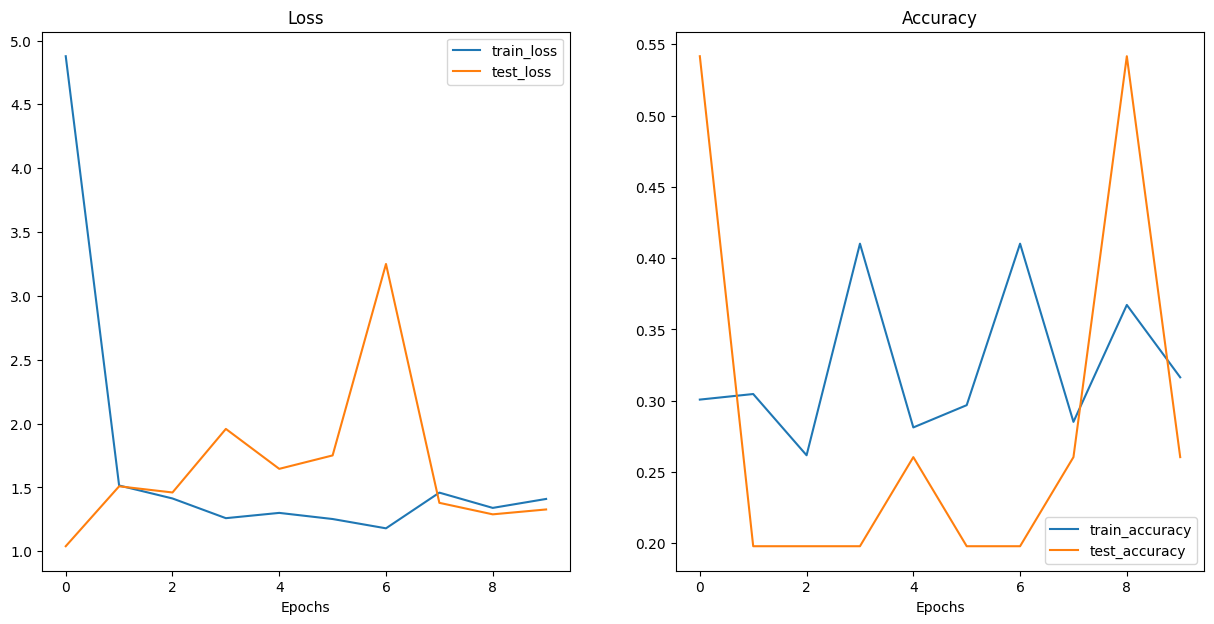

In [57]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# 10. Using pretrained weights

In [58]:
import torch
import torchvision


In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [60]:
# get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# setup vit model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [61]:
summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [62]:
# freeze the base params
for params in pretrained_vit.parameters():
    params.requires_grad = False

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [63]:
# update classifier head to match our class_names
set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)
summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

# 10.3 Preparing data for the pretrained ViT model


In [64]:
# get automatic transforms from pretrained vit weights ie data must be formatted like your borrowed mode
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [65]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
                                                                                                    train_dir=train_dir,
                                                                                                    test_dir=test_dir,
                                                                                                    transform=vit_transforms, # use manually created transforms
                                                                                                    batch_size=BATCH_SIZE
                                                                                                )

train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ef6800d0940>,
 ['pizza', 'steak', 'sushi'])

## 10.4 train feature extractor vit model

In [66]:
#run on gpu

from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


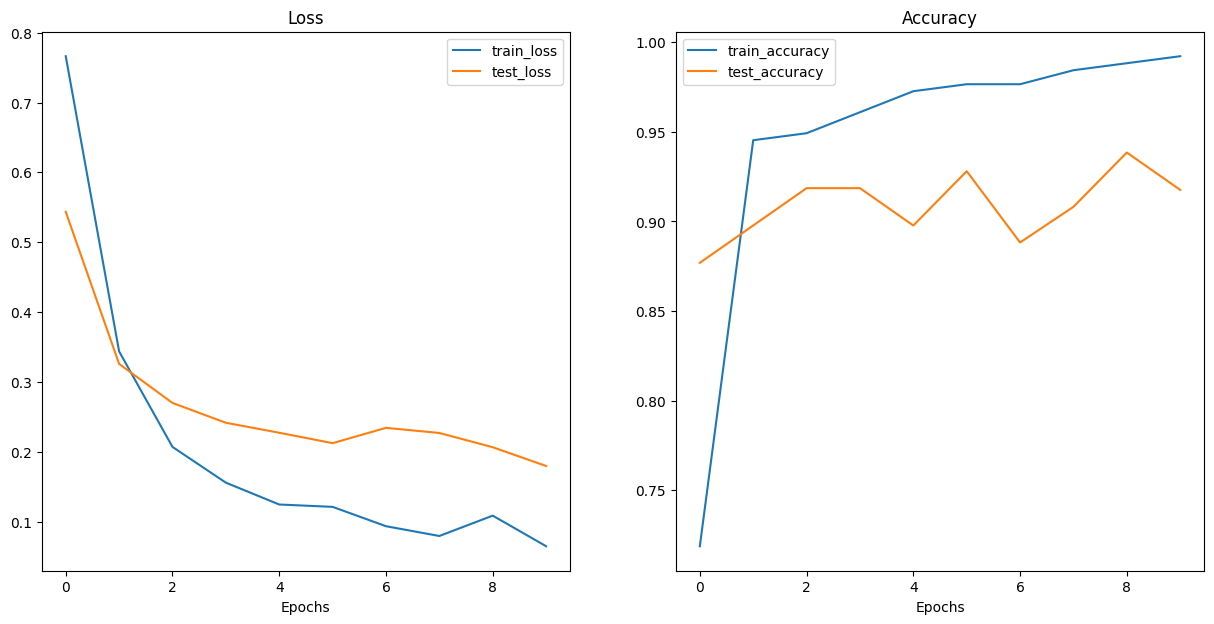

In [67]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [68]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [69]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicting on a custom image

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


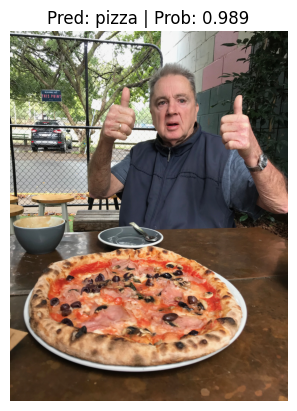

In [73]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)